# Data Science Charcuterie: Clustering

#### Kate Stadelman

The following notebook showcases different clustering techniques on numeric features of the Palmer Penguin dataset (Gorman et al., 2014). Clustering is an unsupervisied learning method that is generally used to find meaningful structure in our data.

In [1]:
from palmerpenguins import load_penguins
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

%matplotlib inline


## Palmer Penguin Dataset
We begin by loading the Palmer Penguin Dataset (Gorman et al., 2014) and creating necessary dataframes and arrays. Previewing the data, we can see that everything loaded correctly. For this clustering exercise, we only keep numeric features, and observations with missing values are removed.

In [2]:
# load the palmer penguin dataset
penguins = load_penguins()
penguins = shuffle(penguins, random_state=36)
penguins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344 entries, 89 to 133
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 24.2+ KB


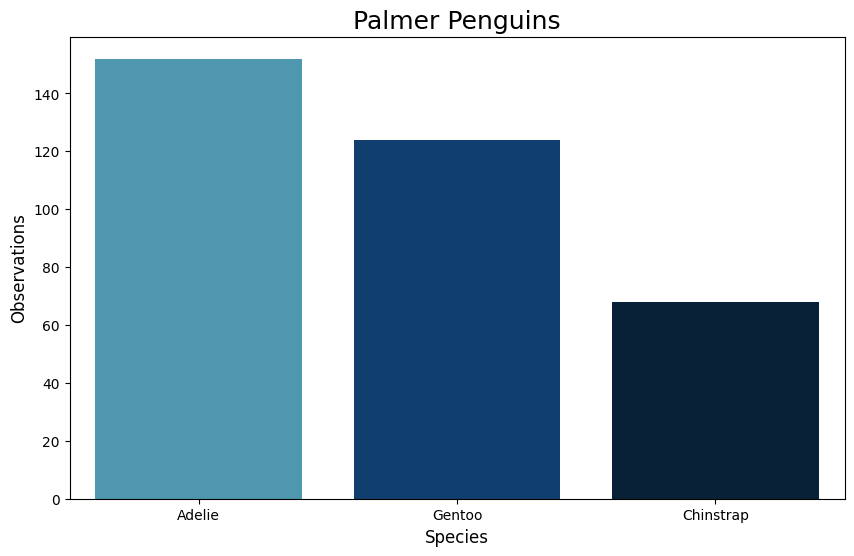

In [3]:
# check distribution of species
plt.figure(figsize=(10,6))
sns.countplot(data=penguins, x='species', palette='ocean_r')
plt.title('Palmer Penguins', fontsize=18)
plt.xlabel('Species', fontsize=12)
plt.ylabel('Observations', fontsize=12)
plt.show()

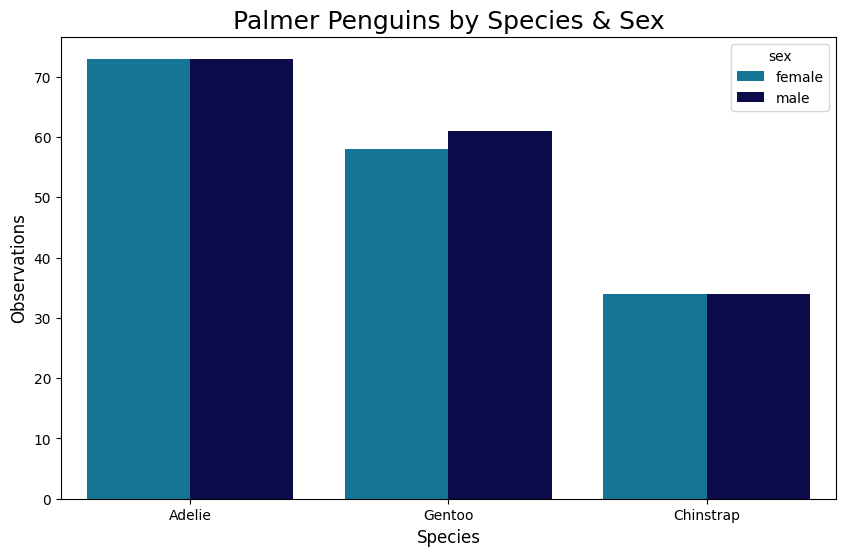

In [4]:
# check distribution of species by sex
plt.figure(figsize=(10,6))
sns.countplot(data=penguins, x='species', hue='sex', palette='ocean_r')
plt.title('Palmer Penguins by Species & Sex', fontsize=18)
plt.xlabel('Species', fontsize=12)
plt.ylabel('Observations', fontsize=12)
plt.show()

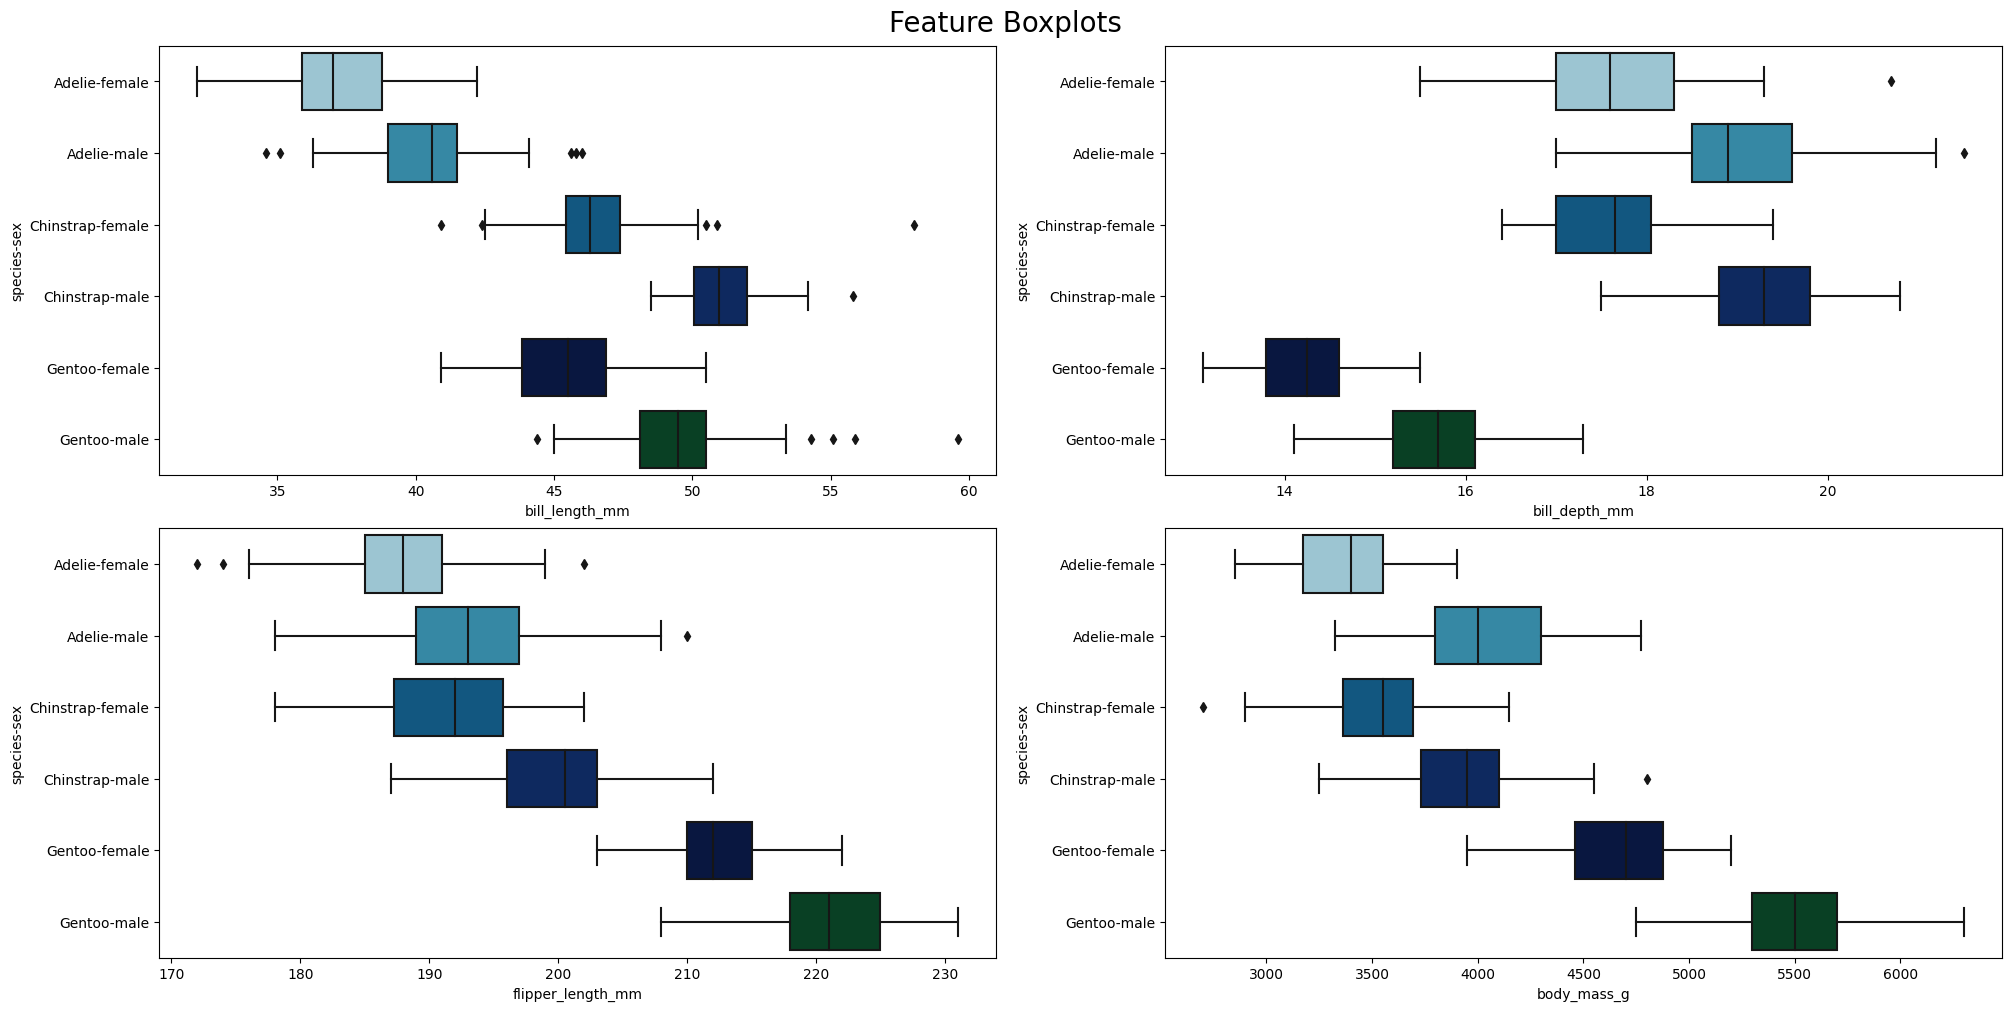

In [5]:
# would it be easier to cluster if we split by sex?
penguins['species-sex'] = penguins['species'] + '-' + penguins['sex']
penguins.head(10)
features = penguins.columns[2:6]

l,w = 2,2
plots = [ [i,j] for i in range(l) for j in range(w) ]
fig, axs = plt.subplots(nrows=l, ncols=w, constrained_layout=True, figsize=(20,10))
fig.suptitle('Feature Boxplots', fontsize=20)
for i in range(len(features)):
    j,k = plots[i]
    sns.boxplot(data=penguins.sort_values(by='species-sex'), x=features[i], y='species-sex', ax=axs[j,k], palette='ocean_r')
plt.show()

Splitting by sex does not eliminate the overlap between Adelie and Chinstrap, so we will cluster together.

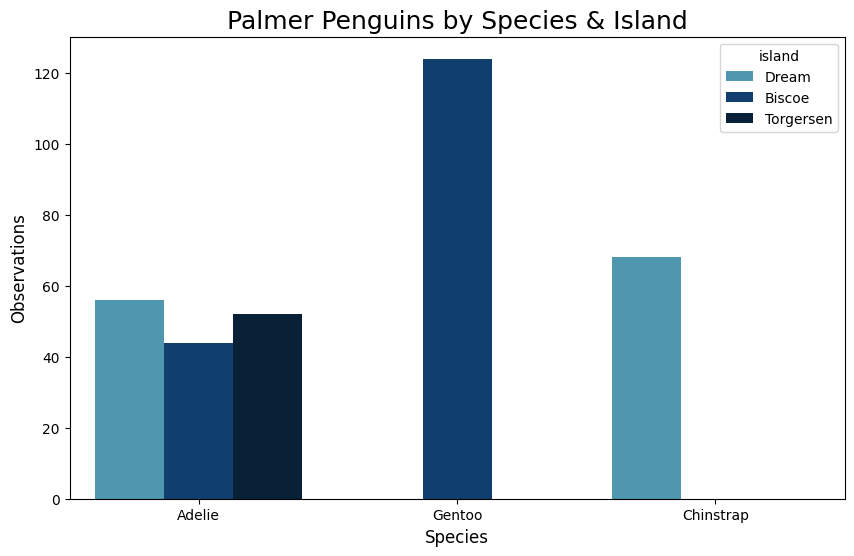

In [6]:
# we won't be using island for this execise, but still interesting to see where each species lives
plt.figure(figsize=(10,6))
sns.countplot(data=penguins, x='species', hue='island', palette='ocean_r')
plt.title('Palmer Penguins by Species & Island', fontsize=18)
plt.xlabel('Species', fontsize=12)
plt.ylabel('Observations', fontsize=12)
plt.show()

In [7]:
# make final dataframe and remove missing values
species_map = { 'Chinstrap': 0, 'Gentoo': 1, 'Adelie': 2 }
species_list = species_map.keys()
df = penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']]
df['target_name'] = penguins['species']
df['target'] = df.target_name.apply(lambda x: species_map[str(x)])
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 89 to 133
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bill_length_mm     342 non-null    float64
 1   bill_depth_mm      342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   target_name        342 non-null    object 
 5   target             342 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 18.7+ KB


In [8]:
# create arrays for models
X = df.iloc[:, :-2].values
y = df.iloc[:, -1].values

# preview data
df.head(10)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,target_name,target
89,38.9,18.8,190.0,3600.0,Adelie,2
62,37.6,17.0,185.0,3600.0,Adelie,2
55,41.4,18.6,191.0,3700.0,Adelie,2
191,48.7,15.7,208.0,5350.0,Gentoo,1
159,46.7,15.3,219.0,5200.0,Gentoo,1
56,39.0,17.5,186.0,3550.0,Adelie,2
210,43.2,14.5,208.0,4450.0,Gentoo,1
229,51.1,16.3,220.0,6000.0,Gentoo,1
231,45.2,16.4,223.0,5950.0,Gentoo,1
114,39.6,20.7,191.0,3900.0,Adelie,2


## PCA
Before we dive into clustering, we first peform Principal Component Analysis (PCA), which allows us reduce dimensionality without sacrificing variance. We will use the PCA-reduced data as a comparison with the original data for all clustering techniques.

It is recommended that we transform all of the features to a standard scale with mean = 0 and standard deviation = 1 prior to performing PCA. In the following code block, we standardize our data and preview the scaled array.

In [9]:
# standardize features to a common scale so PCA works properly
X_std = StandardScaler().fit_transform(X)

# show standardized feature values
print(X_std[:10])

[[-0.92118525  0.83616164 -0.77737308 -0.75145916]
 [-1.15964752 -0.07666174 -1.13346951 -0.75145916]
 [-0.46260394  0.73473682 -0.70615379 -0.6265811 ]
 [ 0.87645346 -0.73592307  0.50457406  1.43390676]
 [ 0.50958841 -0.93877271  1.2879862   1.24658968]
 [-0.90284199  0.17690031 -1.06225022 -0.81389818]
 [-0.13242541 -1.34447199  0.50457406  0.31000429]
 [ 1.31669151 -0.43164861  1.35920549  2.24561409]
 [ 0.23443963 -0.3809362   1.57286334  2.18317507]
 [-0.79278248  1.79969743 -0.70615379 -0.376825  ]]


To help us determine the appropriate number of PCA dimensions, we compute a covariance matrix and plot the cumulative sum of explained variances by number of included features.

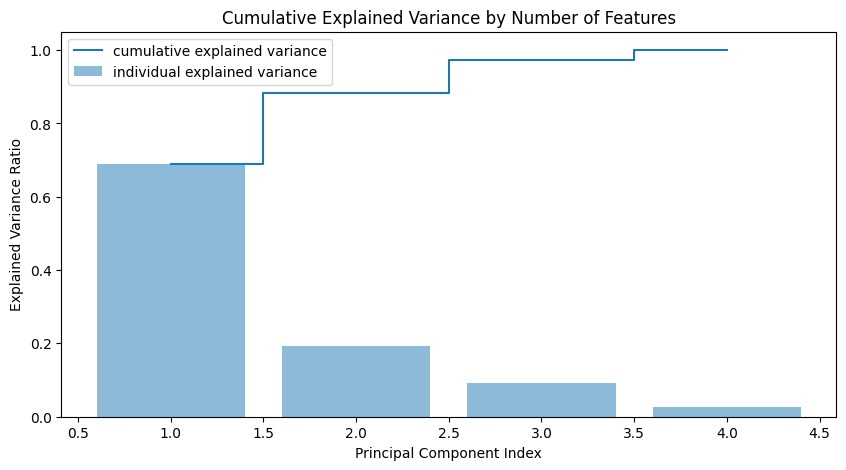

In [10]:
# compute covariance matrix and visualize cumulative sum of explained variances to choose right number of PCA dimensions
cov_mat = np.cov(X_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# calculate cumulative sum of explained variances
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.figure(figsize=(10,5))
plt.bar(range(1,5), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,5), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.title('Cumulative Explained Variance by Number of Features')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component Index')
plt.legend(loc='best')
plt.show()

Reviewing the above plot, it appears that we retain almost all explained variance with only two features. We now perform PCA using two as our number of principal components. Additionally, we look at which features are most closely aligned to each of our principal components so that we can use these features to compare clustering outcomes between the original and PCA datasets.

In [11]:
# perform PCA with two features
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_std)
df_pca = pd.DataFrame(data = principalComponents, columns = ['pca_1', 'pca_2'])
df_pca['target_name'] = df['target_name'].values
df_pca['target'] = df['target'].values
X_pca = df_pca.iloc[:, :-2].values

# review PCA output 
print('Explained Variance Ratio:', pca.explained_variance_ratio_)
print(pd.DataFrame(pca.components_.T, columns = ['pca_1', 'pca_2'], index=df.columns[:-2]))

Explained Variance Ratio: [0.68843878 0.19312919]
                      pca_1     pca_2
bill_length_mm     0.455250  0.597031
bill_depth_mm     -0.400335  0.797767
flipper_length_mm  0.576013  0.002282
body_mass_g        0.548350  0.084363


The first principal component explains 68.8% of the variance and aligns relatively similarly to flipper length and body mass. We will use flipper length in our comparisons to the original dataset because it has the highest alignment value (0.576). The second principal component explains 19.3% of the variance and aligns very closely with bill depth.

Now, let's compare scatter plots of the original and PCA datasets.

In [12]:
# scatter plot of original data
fig = px.scatter(df, x='flipper_length_mm', y='bill_depth_mm', color='target_name', color_discrete_sequence=["orange","green","blue"],
                 title='Penguin Flipper Length & Bill Depth by Species', width=1000, height=600)
fig.show()

In [13]:
# scatter plot of PCA data
fig = px.scatter(df_pca, x='pca_1', y='pca_2', color='target_name', color_discrete_sequence=["orange","green","blue"],
                 title='Penguin Principal Components by Species', width=1000, height=600)
fig.show()

Comparing the two scatterplots, we have a hint that the PCA dataset might perform better in clustering because Adelie and Chinstrap overlap less. Now that we have both original and PCA datasets, we will continue with our chosen clustering techniques of K-Means, Hierarchical Agglomerative Clustering, and DBScan.

## K-Means Clustering

K-Means is a widely popular unsupervised clustering method that seeks to partition the data into k groups. Centroids are points that represent the summary of the cluster and are randomly initialized. Data points are assigned to each cluster based on which centroid is closest, and then after all data is assigned, centroids are recomputed. This process continues until the centroids have stabalized or we have reached a defined number of iterations. 

### Elbow Plot

In order to perform K-Means, we need to know how many clusters k to use. The most commonly accepted method to determine k is to generate an Elbow plot and find where the curve pivots from sharp decline to flattening out (the elbow).

In our plot below, we see that the most appropriate value for k is 3.

In [14]:
# Elbow plot to determine the number of clusters
ks = [ k for k in range(1,11) ]
inertias = []
for k in ks:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=8)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)
df_elbow = pd.DataFrame(list(zip(ks,inertias)), columns=['Number of Clusters k', 'Inertia'])

fig = px.line(df_elbow, x='Number of Clusters k', y='Inertia', markers=True, title='Elbow Method for Determining Optimal Number of Clusters', width=800, height=400)
fig.show()

### K-Means Clustering of Original Data

In the following section, we apply K-Means to the original dataset.

In [15]:
# create K-Means model and predictions
k = 3
kmeans_orig = KMeans(n_clusters = k, n_init='auto', random_state=65)
kmeans_orig.fit(X)
y_kmeans_orig = kmeans_orig.predict(X)

In [16]:
# save off K-means data for analysis and visualizations
df_kmeans_orig = df.copy()
df_kmeans_orig['cluster'] = y_kmeans_orig

# check which cluster generally represents which spieces for quality assessment
df_kmeans_orig_pivot = pd.DataFrame(pd.pivot_table(df_kmeans_orig[['target','cluster','flipper_length_mm']], index=['target'], columns=['cluster'], 
                                                   aggfunc=np.count_nonzero))
df_kmeans_orig_pivot = df_kmeans_orig_pivot.reset_index()
df_kmeans_orig_pivot

target flipper_length_mm            
cluster                        0     1     2
0            0              22.0   NaN  46.0
1            1              42.0  81.0   NaN
2            2              53.0   NaN  98.0

In [17]:
# add in centroids for visualizations
centroids_orig = pd.DataFrame(kmeans_orig.cluster_centers_, columns = ['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g'])
centroids_orig['target_name'] = 'centroid'
centroids_orig['cluster'] = -1
df_kmeans_orig = pd.concat([df_kmeans_orig, centroids_orig], ignore_index=True)
df_kmeans_orig.sort_values(by=['target_name', 'cluster'], inplace=True)

From our K-Means output, we create a scatter plot that represents the true species by color and the generated cluster by point shape. The centroids are plotted separately in red. At first glance, our clustering performed well for Gentoo, but some mixed results for Adelie and Chinstrap.

In [18]:
# K-Means scatter plot with species by color and cluster by shape
fig = px.scatter(df_kmeans_orig, x="flipper_length_mm", y="bill_depth_mm", color="target_name", color_discrete_sequence=["orange","green","blue","red"],
                 symbol="cluster", title='K-Means Flipper Length & Bill Depth by Species and Cluster', width=1000, height=600)
fig.show()

For our quality assessment, we generate a confusion matrix, a classification report, and a silhouette coefficient. We will discuss outcomes more thoroughly after completeing K-Meanas on our PCA dataset for comparison.

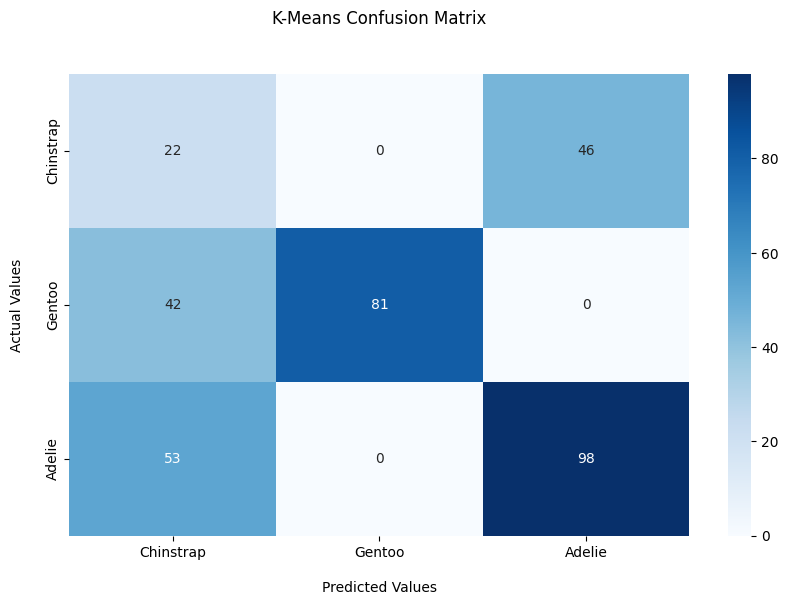

In [19]:
# K-Means confusion matrix
kmeans_conf_orig = confusion_matrix(y, y_kmeans_orig)
plt.figure(figsize = (10,6))
ax = sns.heatmap(kmeans_conf_orig, annot=True, cmap='Blues')
ax.set_title('K-Means Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n')
ax.yaxis.set_ticklabels(species_list)
ax.xaxis.set_ticklabels(species_list)
plt.show()

In [20]:
# K-Means classification report
print('\nK-Means Classification Report\n')
print(classification_report(y, y_kmeans_orig, target_names=species_list))


K-Means Classification Report

              precision    recall  f1-score   support

   Chinstrap       0.19      0.32      0.24        68
      Gentoo       1.00      0.66      0.79       123
      Adelie       0.68      0.65      0.66       151

    accuracy                           0.59       342
   macro avg       0.62      0.54      0.57       342
weighted avg       0.70      0.59      0.63       342



Silhouette Coefficients (also called Silhouette Scores) range in value between -1 (the worst) and 1 (the best), with values near 0 representing overlapping clusters.

In [21]:
# K-Means original data silhouette score
print('K-Means Silhouette Score:', silhouette_score(X, y_kmeans_orig, metric='euclidean'))

K-Means Silhouette Score: 0.558091433657973


### K-Means Clustering of PCA Data

In the following section, we apply K-Means to the PCA dataset.

In [22]:
# create K-Means model and predictions
kmeans_pca = KMeans(n_clusters = k, n_init='auto', random_state=8)
kmeans_pca.fit(X_pca)
y_kmeans_pca = kmeans_pca.predict(X_pca)

In [23]:
# save off K-means data for analysis and visualizations
df_kmeans_pca = df_pca.copy()
df_kmeans_pca['cluster'] = y_kmeans_pca

# find out which cluster generally represents which spieces for quality assessment
df_kmeans_pca_pivot = pd.DataFrame(pd.pivot_table(df_kmeans_pca[['target','cluster','pca_1']], index=['target'], columns=['cluster'], aggfunc=np.count_nonzero))
df_kmeans_pca_pivot = df_kmeans_pca_pivot.reset_index()
df_kmeans_pca_pivot


target  pca_1             
cluster             0     1      2
0            0    8.0  60.0    NaN
1            1    NaN   NaN  123.0
2            2  118.0  33.0    NaN

In [24]:
cluster_map = { 0: 2, 1: 0, 2: 1 }
df_kmeans_pca['cluster'] = df_kmeans_pca.cluster.apply(lambda x: cluster_map[x])
y_kmeans_pca = df_kmeans_pca.cluster

In [25]:
# add in centroids for visualizations
centroids_pca = pd.DataFrame(kmeans_pca.cluster_centers_, columns = ['pca_1', 'pca_2'])
centroids_pca['target_name'] = 'centroid'
centroids_pca['cluster'] = -1
df_kmeans_pca = pd.concat([df_kmeans_pca,centroids_pca], ignore_index=True)
df_kmeans_pca.sort_values(by=['target_name', 'cluster'], inplace=True)

We create a similar scatter plot for the PCA data that represents the true species by color and the generated cluster by point shape. The centroids are plotted separately in red. Clustering performed extremely well for Gentoo, but some mixed results for Adelie and Chinstrap. Additionally, it appears that K-Means performed better on the PCA data than on the original data.

In [26]:
# K-Means scatter plot with species by color and cluster by shape
fig = px.scatter(df_kmeans_pca, x='pca_1', y='pca_2', color='target_name', color_discrete_sequence=["orange","green","blue","red"], 
                 symbol='cluster', title='K-Means Principal Components by Species and Cluster', width=1000, height=600)
fig.show()

Again, we generate a confusion matrix, classification report, and sihoulette coefficient.

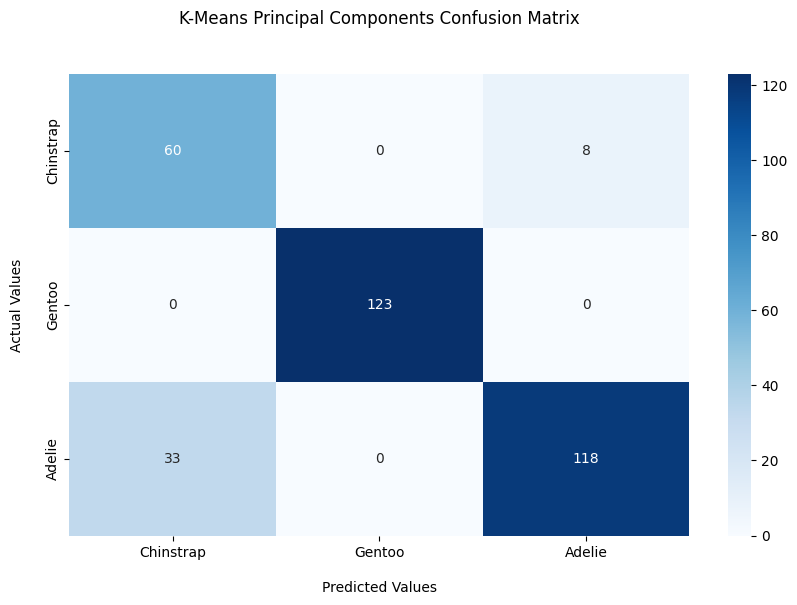

In [27]:
# K-Means confusion matrix
kmeans_conf_pca = confusion_matrix(y, y_kmeans_pca)

plt.figure(figsize = (10,6))
ax = sns.heatmap(kmeans_conf_pca, annot=True, cmap='Blues', fmt='g')
ax.set_title('K-Means Principal Components Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');
ax.xaxis.set_ticklabels(species_list)
ax.yaxis.set_ticklabels(species_list)
plt.show()

In [28]:
# K-Means PCA data classification report
print('\nK-Means Principal Components Classification Report\n')
print(classification_report(y, y_kmeans_pca, target_names=species_list))


K-Means Principal Components Classification Report

              precision    recall  f1-score   support

   Chinstrap       0.65      0.88      0.75        68
      Gentoo       1.00      1.00      1.00       123
      Adelie       0.94      0.78      0.85       151

    accuracy                           0.88       342
   macro avg       0.86      0.89      0.87       342
weighted avg       0.90      0.88      0.88       342



In [29]:
# K-Means PCA data silhouette score
print('K-Means Principal Component Silhouette Score:', silhouette_score(X_pca, y_kmeans_pca, metric='euclidean'))

K-Means Principal Component Silhouette Score: 0.5391033351129074


### K-Means Discussion

Looking through the visualizations, confusion matrices, and classification reports, we can conclude that for PCA greatly improved our K-Means results. Interestingly, the silhouette score was nominally better for the original data than the PCA data. However, this is not all that surprising given the large overlap between Adelie and Chinstrap.

## Hierarchical Agglomerative Clustering

The goal of hierarchical clustering is to take n points in d-dimensional space to create nested partitions that can be visualized in a tree or hierarchy. Agglomerative clustering is a "bottom-up" method that builds from a single point in a leaf to all points in the root.

### Agglomerative Clustering of Original Data

In the following section, we apply Agglomerative Clustering to the original dataset.

We try average, complete, and ward linkage methods, and determine which one is best based on the highest rand score.

In [30]:
# Agglomerative clustering
agg_avg_orig = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='average')
y_agg_avg_orig = agg_avg_orig.fit_predict(X)
agg_avg_rand_orig = adjusted_rand_score(y, y_agg_avg_orig)
print('Average Rand Score:', agg_avg_rand_orig)

agg_comp_orig = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')
y_agg_comp_orig = agg_comp_orig.fit_predict(X)
agg_comp_rand_orig = adjusted_rand_score(y, y_agg_comp_orig)
print('Complete Rand Score:', agg_comp_rand_orig)

agg_ward_orig = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
y_agg_ward_orig = agg_ward_orig.fit_predict(X)
agg_ward_rand_orig = adjusted_rand_score(y, y_agg_ward_orig)
print('Ward Rand Score:', agg_ward_rand_orig)

Average Rand Score: 0.3287338621600612
Complete Rand Score: 0.33190647086017655
Ward Rand Score: 0.37537902348266183


From the results above, we move foward using the ward linkage method.

In [31]:
# save off best agglomerative clustering model
df_agg_orig = df.copy()
df_agg_orig['cluster'] = y_agg_ward_orig
df_agg_orig.sort_values(by=['target', 'cluster'], inplace=True)

# find out which cluster generally represents which spieces for quality assessment
df_agg_orig_pivot = pd.DataFrame(pd.pivot_table(df_agg_orig[['target','cluster','flipper_length_mm']], index=['target'], columns=['cluster'],
                                                aggfunc=np.count_nonzero))
df_agg_orig_pivot = df_agg_orig_pivot.reset_index()
df_agg_orig_pivot

target flipper_length_mm            
cluster                        0     1     2
0            0              61.0   NaN   7.0
1            1               6.0  81.0  36.0
2            2             126.0   NaN  25.0

In [32]:
agg_cluster_map = { 0: 2, 1: 1, 2: 0 }
df_agg_orig['cluster'] = df_agg_orig.cluster.apply(lambda x: agg_cluster_map[x])

To visuzalize our Agglomerative clustering output, we create a dendrogram, as well as a scatter plot that represents the true species by color and the generated cluster by point shape.

It is difficult to tell from the initial plots whether Agglomerative performed better or worse than K-Means.

In [33]:
# a sidewise dendrogram can work well with long labels
fig = ff.create_dendrogram(X, orientation='left', labels=df_agg_orig.target_name.values)
fig.update_layout(title='Agglomerative Clusters', width=600, height=3500)
fig.show()

In [34]:
# Agglomerative clustering scatter plot with species by color and cluster by shape
fig = px.scatter(df_agg_orig, x="flipper_length_mm", y="bill_depth_mm", color="target_name", color_discrete_sequence=["orange","green","blue"],
                 symbol="cluster", title='Agglomerative Flipper Length vs. Bill Depth by Species and Cluster', width=1000, height=600)
fig.show()

For quality assessment, we generate a confusion matrix and classification report.

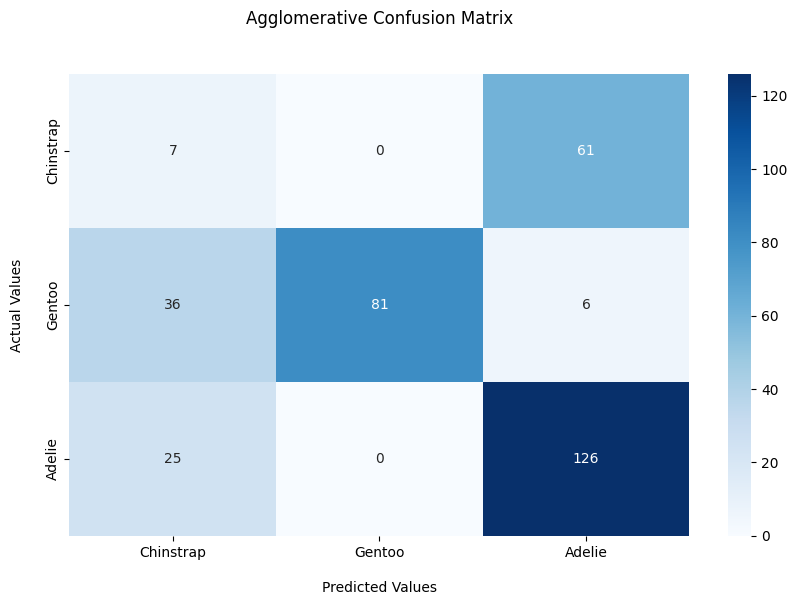

In [35]:
# Agglomerative confusion matrix
agg_conf_orig = confusion_matrix(df_agg_orig.target.values, df_agg_orig.cluster.values)

plt.figure(figsize = (10,6))
ax = sns.heatmap(agg_conf_orig, annot=True, cmap='Blues', fmt='g')
ax.set_title('Agglomerative Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');
ax.xaxis.set_ticklabels(species_list)
ax.yaxis.set_ticklabels(species_list)
plt.show()

In [36]:
# Agglomerative classification report
print('\nAgglomerative Classification Report\n')
print(classification_report(df_agg_orig.target.values, df_agg_orig.cluster.values, target_names=species_list))


Agglomerative Classification Report

              precision    recall  f1-score   support

   Chinstrap       0.10      0.10      0.10        68
      Gentoo       1.00      0.66      0.79       123
      Adelie       0.65      0.83      0.73       151

    accuracy                           0.63       342
   macro avg       0.59      0.53      0.54       342
weighted avg       0.67      0.63      0.63       342



From the confusion matrix and classification report, it appears that Agglomerative clustering nominally outperformed K-Means on the original data. In the next section, we will perform the same Agglomerative clusterting on the PCA data for comparison.

### Agglomerative Clustering of PCA Data

In the following section, we apply Agglomerative clustering to the PCA dataset.

We try average, complete, and ward linkage methods, and determine which one is best based on the highest rand score.

In [37]:
# Agglomerative clustering
agg_avg_pca = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')
y_agg_avg_pca = agg_avg_orig.fit_predict(X_pca)
agg_avg_rand_pca = adjusted_rand_score(y, y_agg_avg_pca)
print('Average Rand Score:', agg_avg_rand_pca)

agg_comp_pca = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
y_agg_comp_pca = agg_comp_orig.fit_predict(X_pca)
agg_comp_rand_pca = adjusted_rand_score(y, y_agg_comp_pca)
print('Complete Rand Score:', agg_comp_rand_pca)

agg_ward_pca = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
y_agg_ward_pca = agg_ward_orig.fit_predict(X_pca)
agg_ward_rand_pca = adjusted_rand_score(y, y_agg_ward_pca)
print('Ward Rand Score:', agg_ward_rand_pca)

Average Rand Score: 0.6505721295468222
Complete Rand Score: 0.7042780990180987
Ward Rand Score: 0.6396951551254995


From the results above, we move foward using the complete linkage method.

In [38]:
# save off best agglomerative clustering model
df_agg_pca = df_pca.copy()
df_agg_pca['cluster'] = y_agg_comp_pca
df_agg_pca.sort_values(by=['target', 'cluster'], inplace=True)

# find out which cluster generally represents which spieces for quality assessment
df_agg_pca_pivot = pd.DataFrame(pd.pivot_table(df_agg_pca[['target','cluster','pca_1']], index=['target'], columns=['cluster'], aggfunc=np.count_nonzero))
df_agg_pca_pivot = df_agg_pca_pivot.reset_index()
df_agg_pca_pivot

target  pca_1             
cluster             0      1     2
0            0    NaN    6.0  62.0
1            1  123.0    NaN   NaN
2            2    NaN  112.0  39.0

In [39]:
agg_cluster_map = { 0: 1, 1: 2, 2: 0 }
df_agg_pca['cluster'] = df_agg_pca.cluster.apply(lambda x: agg_cluster_map[x])

In [40]:
# Agglomerative dendrogram
fig = ff.create_dendrogram(X_pca, orientation='left', labels=df_agg_pca.target_name.values)
fig.update_layout(title='PCA Agglomerative Clusters', width=600, height=3500)
fig.show()

In [41]:
# Agglomerative clustering scatter plot with species by color and cluster by shape
fig = px.scatter(df_agg_pca, x="pca_1", y="pca_2", color="target_name", color_discrete_sequence=["orange","green","blue"], 
                 symbol="cluster", title='Agglomerative Principal Components by Species and Cluster', width=1000, height=600)
fig.show()

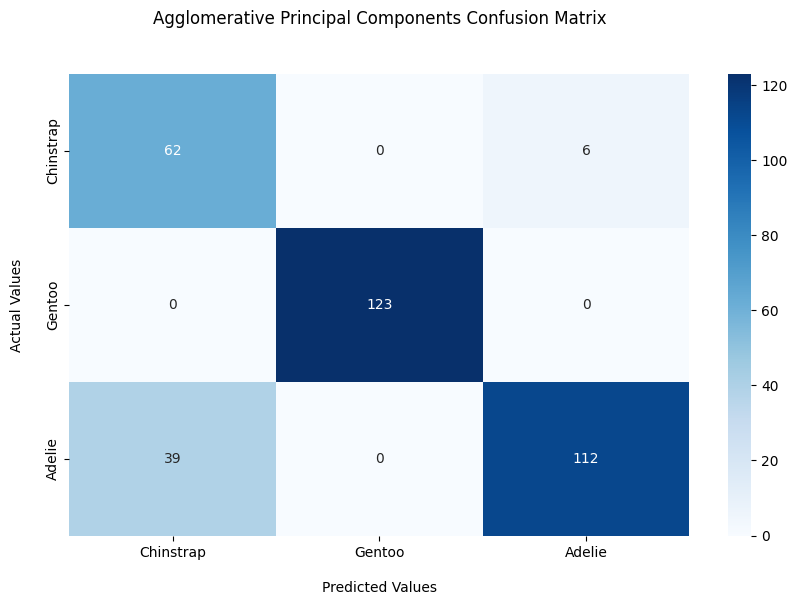

In [42]:
# Agglomerative confusion matrix
agg_conf_pca = confusion_matrix(df_agg_pca.target.values, df_agg_pca.cluster.values)

plt.figure(figsize = (10,6))
ax = sns.heatmap(agg_conf_pca, annot=True, cmap='Blues', fmt='g')
ax.set_title('Agglomerative Principal Components Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');
ax.xaxis.set_ticklabels(species_list)
ax.yaxis.set_ticklabels(species_list)
plt.show()

In [43]:
# Agglomerative origina data classification report
print('\nAgglomerative Principal Components Classification Report\n')
print(classification_report(df_agg_pca.target.values, df_agg_pca.cluster.values, target_names=species_list))


Agglomerative Principal Components Classification Report

              precision    recall  f1-score   support

   Chinstrap       0.61      0.91      0.73        68
      Gentoo       1.00      1.00      1.00       123
      Adelie       0.95      0.74      0.83       151

    accuracy                           0.87       342
   macro avg       0.85      0.88      0.86       342
weighted avg       0.90      0.87      0.87       342



### Agglomerative Discussion

Agglomerative Clustering grouped all of Gentoo into a single cluster, and Chinstrap almost into a single cluster. However, it did not cluster as many Adelie correctly as K-Means. Once again, PCA improved our results! 

## DBScan

DBScan is a density-based clustering method, which relies on the density of points in a cluster rather than the distance between the points.

### DBScan Clustering of Original Data

In the following section, we apply DBScan to the original dataset.

The Knee Method helps us find the optimal value of EPS, a main parameter of DBScan. We select the measurement at which maximum curvature or a sharp change happens.

In the plot below, we see that for the original dataset, the most appropriate value for EPS is 28.25.

In [44]:
# Knee method
nearest_neighbors = NearestNeighbors(n_neighbors=3)
nearest_neighbors.fit(X)
distances, indices = nearest_neighbors.kneighbors(X)
distances = np.sort(distances, axis=0)[:, 1]
iterations = [ i for i in range(len(distances)) ]
df_knee = pd.DataFrame(list(zip(iterations,distances)), columns=['Iteration','Distance'])

fig = px.line(df_knee, x='Iteration', y='Distance', title='Knee Method for Determining Optimal Value of EPS', width=800, height=400)
fig.show()

In [45]:
# DBScan clustering
db_orig = DBSCAN(eps=28.25, min_samples=3, metric='euclidean', p=2)
y_db_orig = db_orig.fit_predict(X)
db_orig_label = { -1 : "noise", 0 : "cluster 1", 1: "cluster 2", 2: "cluster 3", 3: "cluster 4" }
y_db_orig_lab = np.array([ db_orig_label.get(i) for i in y_db_orig ])

In [46]:
# save off DBscan model
df_db_orig = df.copy()
df_db_orig['cluster'] = y_db_orig_lab
df_db_orig.sort_values(by=['target', 'cluster'], inplace=True)

DBScan labels "noise" points with a cluster value of -1. Additionally, our tuned parameters resulted in an extra cluster. Because of this, we switch up our scatter plot to show the clusters/noise by color and target spieces by shape.

In [47]:
# DBScan clustering scatter plot with species by shape and cluster by color
fig = px.scatter(df_db_orig, x="flipper_length_mm", y="bill_depth_mm", color="cluster", symbol="target_name", 
                 title='DBScan Flipper Length vs. Bill Depth by Species and Cluster', width=1000, height=600)
fig.show()

We will not compute a confusion matrix for DBScan because of the extra clusters and noise designation, but we will calculate the silhouette score.

In [48]:
# DBScan silhouette score
print('DBScan Silhouette Score:', silhouette_score(X, y_db_orig_lab, metric='euclidean'))

DBScan Silhouette Score: -0.15954876603235923


### DBScan Clustering of PCA Data

In the following section, we apply DBScan to the PCA dataset.

For the PCA dataset, the most appropriate value for EPS is roughly 0.23.

In [49]:
# Knee method
nearest_neighbors = NearestNeighbors(n_neighbors=3)
nearest_neighbors.fit(X_pca)
distances, indices = nearest_neighbors.kneighbors(X_pca)
distances = np.sort(distances, axis=0)[:, 1]
iterations = [ i for i in range(len(distances)) ]
df_knee = pd.DataFrame(list(zip(iterations,distances)), columns=['Iteration','Distance'])

fig = px.line(df_knee, x='Iteration', y='Distance', title='Knee Method for Determining Optimal Value of EPS', width=800, height=400)
fig.show()

In [50]:
# DBScan clustering
db_pca = DBSCAN(eps=0.23, min_samples=3, metric='euclidean')
y_db_pca = db_pca.fit_predict(X_pca)
db_pca_label = { -1 : "noise", 0 : "cluster 1", 1: "cluster 2", 2: "cluster 3", 3: "cluster 4" }
y_db_pca_lab = np.array([ db_pca_label.get(i) for i in y_db_pca ])

In [51]:
# save off DBScan model
df_db_pca = df_pca.copy()
df_db_pca['cluster'] = y_db_pca_lab
df_db_pca.sort_values(by=['target', 'cluster'], inplace=True)

Again, we create our scatter plot to show the clusters/noise by color and target spieces by shape.

In [52]:
# DBScan clustering scatter plot with species by shape and cluster by color
fig = px.scatter(df_db_pca, x="pca_1", y="pca_2", color="cluster", symbol="target_name", 
                 title='DBScan Principal Components by Species and Cluster', width=1000, height=600)
fig.show()

In [53]:
# DBScan silhouette score
print('DBScan Principal Components Silhouette Score:', silhouette_score(X_pca, y_db_pca_lab, metric='euclidean'))

DBScan Principal Components Silhouette Score: 0.16950281891004695


### DBScan Discussion

DBScan results were not so hot! On a positive note, it tagged a number of points that graphically appear to be outliers as noise. However, it could not distinguish between Adelie and Chinstrap.

## Conclusion

In this clustering analysis of the Palmer Penguin dataset (Gorman et al., 2014), we employed Principal Component Analysis to reduce the dimensionality of our data while maintaining variance. For each clustering method performed, the PCA dataset improved results.

We attempted K-Means, Agglomerative Clustering, and DBScan. Both K-Means and Agglomerative were successful enough to create confusion matrices and classification reports. Rand scores were generated for the Agglomerative models, while Silhouette scores were used to evaluate K-Means and DBScan. We repeat a few choice measures for reference below.

The following list ranks clustering methods from best to worst in terms of the resulting clusters correctly representing the species:
1. K-Means
2. Agglomerative Clustering
2. DBScan

In [54]:
print('K-MEANS')
print('\nK-Means Classification Report\n')
print(classification_report(y, y_kmeans_pca, target_names=species_list))
print('K-Means Silhouette Score:', silhouette_score(X_pca, y_kmeans_pca, metric='euclidean'))

K-MEANS

K-Means Classification Report

              precision    recall  f1-score   support

   Chinstrap       0.65      0.88      0.75        68
      Gentoo       1.00      1.00      1.00       123
      Adelie       0.94      0.78      0.85       151

    accuracy                           0.88       342
   macro avg       0.86      0.89      0.87       342
weighted avg       0.90      0.88      0.88       342

K-Means Silhouette Score: 0.5391033351129074


In [55]:
print('\n\nAGGLOMERATIVE')
print('\nAgglomerative Classification Report\n')
print(classification_report(df_agg_pca.target.values, df_agg_pca.cluster.values, target_names=species_list))
print('Agglomerative Average Rand Score:', agg_comp_pca)



AGGLOMERATIVE

Agglomerative Classification Report

              precision    recall  f1-score   support

   Chinstrap       0.61      0.91      0.73        68
      Gentoo       1.00      1.00      1.00       123
      Adelie       0.95      0.74      0.83       151

    accuracy                           0.87       342
   macro avg       0.85      0.88      0.86       342
weighted avg       0.90      0.87      0.87       342

Agglomerative Average Rand Score: AgglomerativeClustering(affinity='euclidean', linkage='complete', n_clusters=3)


## References

* Gorman KB, Williams TD, Fraser WR (2014) Ecological Sexual Dimorphism and Environmental Variability within a Community of Antarctic Penguins (Genus Pygoscelis). PLoS ONE 9(3): e90081. https://doi.org/10.1371/journal.pone.0090081